## multiple roc, accuracy, try remove icd features, rerun using new features, feature importance using color map, scatter plot 

In [1]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator

from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer

%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools

#matrix inverse
from numpy.linalg import inv

#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
def get_ml_data(dat, patid, test_size = 0.2, if_stimulated = 'all', if_itd = True, if_scaler = 0, if_remove_icd = 1):
    dat = dat.loc[dat.loc[:,'patid'] == patid]
    y = dat.loc[:,'label']
    drop_list = ['label', 'region_start_time', 'patid', 'epoch', 'if_stimulated']
    if if_remove_icd:
        drop_list.append('i12')
        drop_list.append('i34')
    X = dat.drop(drop_list, axis = 1, inplace = False)
    
    y=y.astype('int')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify = y)
    scaler = preprocessing.StandardScaler().fit(X_train)
    if if_scaler:
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)    
    
        
    return X_train, X_test, y_train, y_test






In [ ]:
def select_data(dat, select_dict):
    


In [34]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import jj_basic_fn as JJ
from sklearn import ensemble


# 1:svm.SVC, 2:svm.LinearSVC, 3:OneVsRestClassifier, 4:svm.SVC+probability=True
               # 5:GaussianNaiveBayes, 6:LogisticRegression, 7:LinearDiscriminantAnalysis
def parameter_tuning(X_train, X_test, y_train, y_test, classifier, C_range_num = 30, 
                     nfold = 10, if_save = 0, if_show = 1):
    #defs is a dictionary to initiate classifier with the parameters that don't need to be tuned
    defs = {}
    defs['classifier'] = classifier
    
    num_instances, num_features = X_train.shape[0], X_train.shape[1]
    n_fold = 10

    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    CV = skf.split(np.zeros(len(y_train)), y_train)
    if classifier==1:
        clf_name = 'Logistic Regression'
        defs['class_weight'] = 'balanced'
        defs['max_iter'] = 200
        C_range = 10 ** np.random.uniform(-2, 2, size = C_range_num)
        tuned_params = dict(penalty=['l1','l2'], C=C_range)
    elif classifier == 2: 
        clf_name = 'SVM'
        defs['class_weight'] = 'balanced'
        kernel_list = ['rbf']    
        gamma_list = [2**i*1/num_features for i in range(1)]
        #degree_list = [2,3,4,5]
        C_range = 10 ** np.random.uniform(-3, 1, size = C_range_num)
        tuned_params = dict(kernel=kernel_list,gamma = gamma_list, C=C_range)

    elif classifier==3:
        clf_name = 'Gaussian Naive Bayes classifier'
        prr = np.ones(2) * (1.0/2)
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        JJ.save_object(clf_try, 'best_estimator_for_' + str(clf_name) + '.p')
        return

    elif classifier==4:
        clf_name = 'Linear Discriminant Analysis'
        prr = np.ones(2) * (1.0/2)
        defs['solver'] = 'eigen'  # 'svd', 'lsqr', 'eigen'
        defs['shrinkage'] = 'auto'
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        JJ.save_object(clf_try, 'best_estimator_for_' + str(clf_name) + '.p')
        return
    elif classifier == 5:
        clf_name = 'decision tree'
        mss_list = [5,10,20,40,60]
        criterion_list = ['entropy']
        max_depth_list = [3,4,5,8,12,18]
        clf_name = 'decision tree'
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list)
    elif classifier == 6:
        clf_name = 'random forest'
        defs['n_estimators'] = 600
        mss_list = [25,30,40]
        criterion_list = ['entropy']
        max_depth_list = [12,13,14,15,16]
        max_features_list = ['auto']
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list, max_features = max_features_list)
    elif classifier == 7:
        clf_name = 'gradient boosting'
        defs['n_estimators'] = 2000
        max_depth_list, subsample_list, learning_rate_list, min_samples_leaf_list = [1,2,3], [0.1,0.15,0.2], [0.01,0.005], [10,20,30] 
        #params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
        #  'learning_rate': 0.01, 'min_samples_leaf': 10, 'random_state': 3}
        tuned_params = dict(max_depth=max_depth_list, subsample = subsample_list,learning_rate = learning_rate_list, min_samples_leaf= min_samples_leaf_list)
    
        
    clf_try = JJ.clf_list(defs)
    
    clf_grid = GridSearchCV(clf_try,
                            param_grid=tuned_params,
                            cv=CV,
                            scoring = 'roc_auc',
                            verbose=1,
                           return_train_score = True)
    clf_grid.fit(X_train, y_train)
    print('Best score: {}'.format(clf_grid.best_score_))
    print('Best parameters: {}'.format(clf_grid.best_params_))

    clf_best = clf_grid.best_estimator_

    y_pred = clf_best.predict(X_test)
    df = pd.DataFrame(clf_grid.cv_results_)
    if if_show:
        JJ.show_result(y_pred, y_test, df, clf_name, if_save = if_save)
        
    if if_save:
        JJ.save_object(df, 'result_df_for_' + str(clf_name) + '.p')
        JJ.save_object(clf_best, 'best_estimator_for_' + str(clf_name) + '.p')
        JJ.save_object(clf_grid.best_score_, 'Best_score_for_' + str(clf_name) + '.p')
        JJ.save_object(clf_grid.best_params_, 'best_params_for_' + str(clf_name) + '.p')

num_classifier = 7


In [4]:
def parameter_tuning_all(patid, C_range_num, if_scaler = 1, if_remove_icd = 1, if_save = 1, if_show = 0):
    X_train, X_test, y_train, y_test = get_ml_data(data, patid, if_scaler = if_scaler, if_remove_icd = if_remove_icd)
    for classifier_int in range(1,num_classifier + 1):
        parameter_tuning(X_train, X_test, y_train, y_test, C_range_num = C_range_num, classifier = classifier_int, if_save = if_save, if_show = if_show)

In [16]:
import pickle
data = pickle.load( open( "../data/ml_ready_data.p", "rb" ) )


In [21]:
parameter_tuning_all('231', C_range_num = 60, if_scaler = 1, if_remove_icd = 1, if_save = 1)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


KeyboardInterrupt: 

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best score: 0.8173992673992674
Best parameters: {'penalty': 'l1', 'C': 0.080439537464654529}
Confusion matrix, without normalization


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   19.2s finished


,params,mean_test_score
4,"{'penalty': 'l1', 'C': 0.0804395374647}",0.817399
14,"{'penalty': 'l1', 'C': 0.0640639752196}",0.817308
2,"{'penalty': 'l1', 'C': 0.304869391529}",0.815842
29,"{'penalty': 'l2', 'C': 0.0420684889206}",0.815842
52,"{'penalty': 'l1', 'C': 0.358376942681}",0.815842
51,"{'penalty': 'l2', 'C': 0.0264765393085}",0.815751
59,"{'penalty': 'l2', 'C': 0.0315214818829}",0.815659
35,"{'penalty': 'l2', 'C': 0.0354199995911}",0.815568
9,"{'penalty': 'l2', 'C': 0.0235162304671}",0.815568
5,"{'penalty': 'l2', 'C': 0.0804395374647}",0.815201


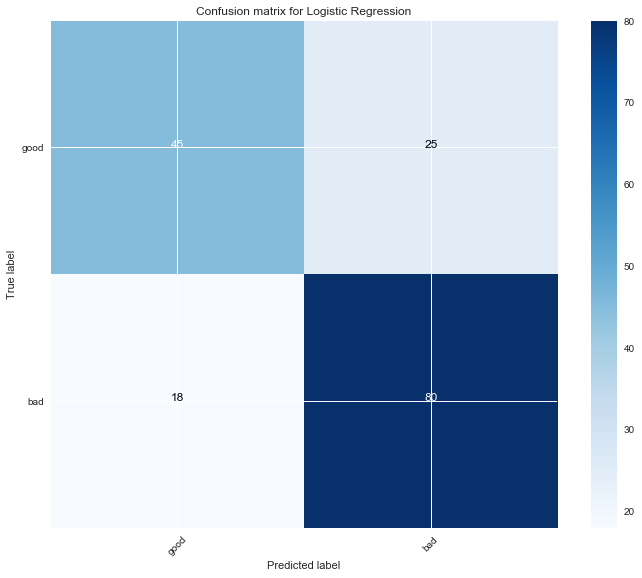

In [43]:
X_train, X_test, y_train, y_test = get_ml_data(data, '231', if_scaler = 1, if_remove_icd = 1)
parameter_tuning(X_train, X_test, y_train, y_test, 1, C_range_num = 30, 
                     nfold = 10, if_save = 1, if_show = 1)

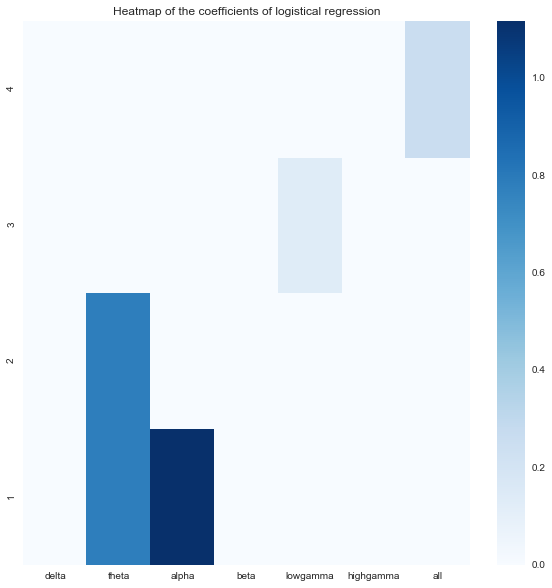

In [7]:
classifier_int = 1
int2name = {1:'Logistic Regression', 2: 'SVM', 3: 'Gaussian Naive Bayes classifier', 4:'Linear Discriminant Analysis', 5:'decision tree', 6:'random forest', 7:'gradient boosting'}
clf_name = int2name[classifier_int]
clf = pickle.load(open('best_estimator_for_' + str(clf_name) + '.p', "rb" ))
coef = np.abs(clf.coef_.reshape(4,7))
powerband = ['delta', 'theta', 'alpha', 'beta', 'lowgamma', 'highgamma', 'all']
channel = ['1', '2','3','4',]
df = pd.DataFrame(coef, index = channel, columns = powerband)
import seaborn as sns
fig = plt.figure()
fig, ax = plt.subplots(1,1, figsize=(10,10))
r = sns.heatmap(coef, cmap = "Blues")
r.set_title("Heatmap of the coefficients of logistical regression")
ax.set_yticklabels(df.index)
ax.set_xticklabels(df.columns)
sns.plt.show()



In [216]:

X_train, X_test, y_train, y_test = get_ml_data(data, '231', if_scaler = 1, if_remove_icd = 1)
#parameter_tuning(X_train, X_test, y_train, y_test, classifier = 1, C_range_num = 100, if_save = 1)
JJ.ensemble_model(X_train, y_train, X_test, y_test, if_save = 0)

0.779761904762


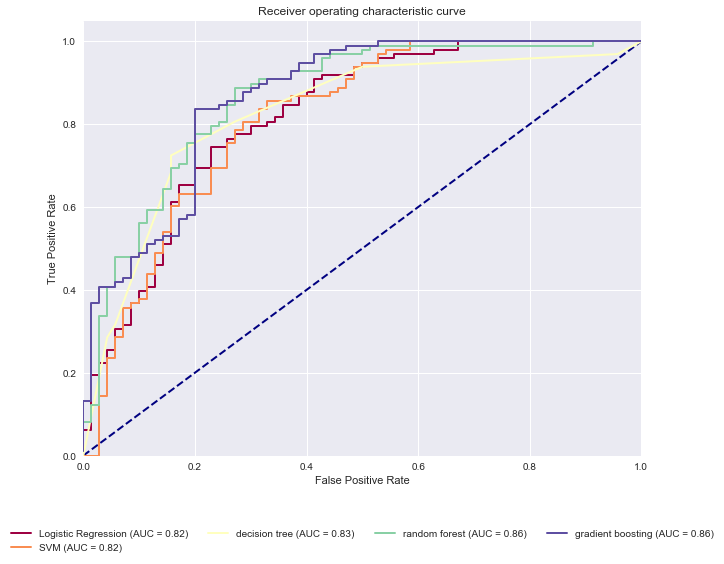

In [14]:
JJ.plot_roc_all(X_test, y_test)

In [37]:
X_train, X_test, y_train, y_test = get_ml_data(data, '231', if_scaler = 1, if_remove_icd = 1)

JJ.scores_estimators(X_test, y_test)

{'decision tree': 0.80750915750915753, 'Logistic Regression': 0.81749084249084247, 'SVM': 0.83791208791208782, 'gradient boosting': 0.86153846153846159, 'random forest': 0.85073260073260071}


,Classifier,AUC
0,gradient boosting,0.861538
1,random forest,0.850733
2,SVM,0.837912
3,Logistic Regression,0.817491
4,decision tree,0.807509


,Classifier,Accuracy
0,gradient boosting,0.815476
1,random forest,0.797619
2,decision tree,0.773810
3,Logistic Regression,0.744048
4,SVM,0.738095


Confusion matrix, without normalization


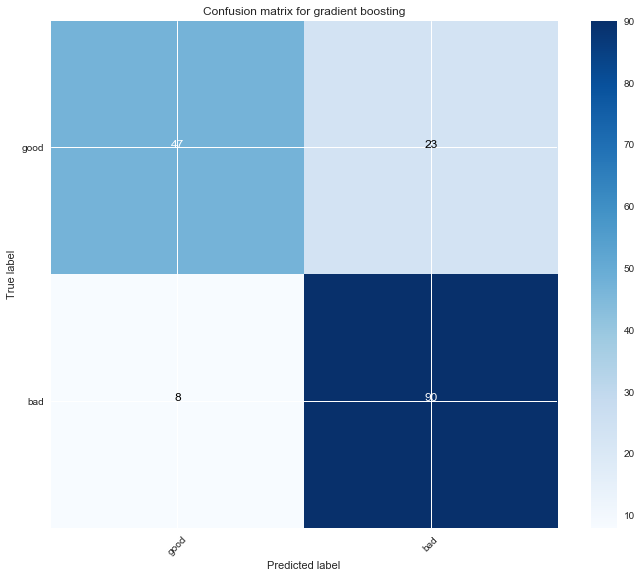

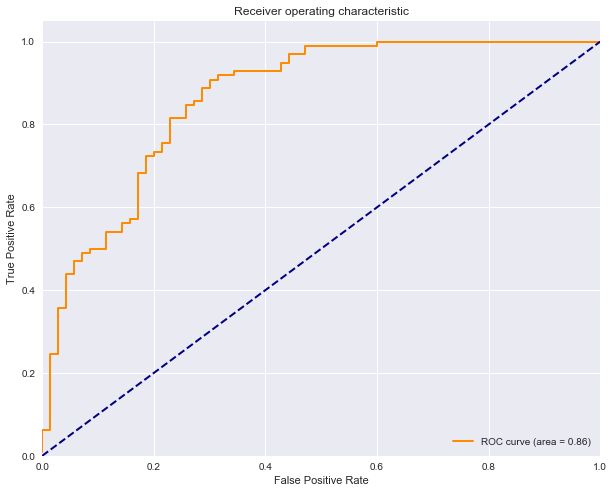

In [38]:
JJ.estimator_performance(7, X_test, y_test, if_plot_c = 1, if_plot_roc = 1)